# Classification binaire des photos

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
import datetime
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
import graphviz
import os

In [2]:
tf.debugging.set_log_device_placement(False)

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Chargement des données
D'abord, nous allons diviser nos données en 3 jeux de données différents.  
- 1 jeu pour entraîner le modèle
- 1 jeu pour valider la performance du modèle pendant l'entraînement
- 1 jeu pour tester la performance du modèle entraîné

In [4]:
BATCH_SIZE = 128
IMG_SIZE = (150, 150)

# Ensemble d'entraînement (70% des données)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "./processed_data/",
    validation_split=0.3,  # 30% pour la combinaison de validation + test
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

temp_dataset = tf.keras.utils.image_dataset_from_directory(
    "./processed_data/",
    validation_split=0.3,  
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

NotFoundError: Could not find directory ./processed_data/

## 2. Normalisation
Les pixels des images sont compris entre 0 et 255.   
Nous allons normaliser ces valeurs entre 0 et 1 car La normalisation des pixels des images rend l'entraînement du modèle plus rapide et plus stable, car elle assure que toutes les entrées ont des valeurs similaires.

In [ ]:
def plot_pixel_distribution(dataset, title="Pixel Distribution"):
    pixels = {}
    
    for images, _ in dataset:
        pixel_value, value_count = np.unique(images, return_counts=1)
        for i in range(len(pixel_value)):
            pixels[pixel_value[i]] = pixels.get(pixel_value[i], 0) + value_count[i]

    plt.figure(figsize=(10, 5))
    plt.hist(pixels.keys(), weights=pixels.values(), bins=256, alpha=0.5, density=True, histtype='bar', stacked=True)
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

Voici la répartition des valeurs des pixels avant la normalisation.

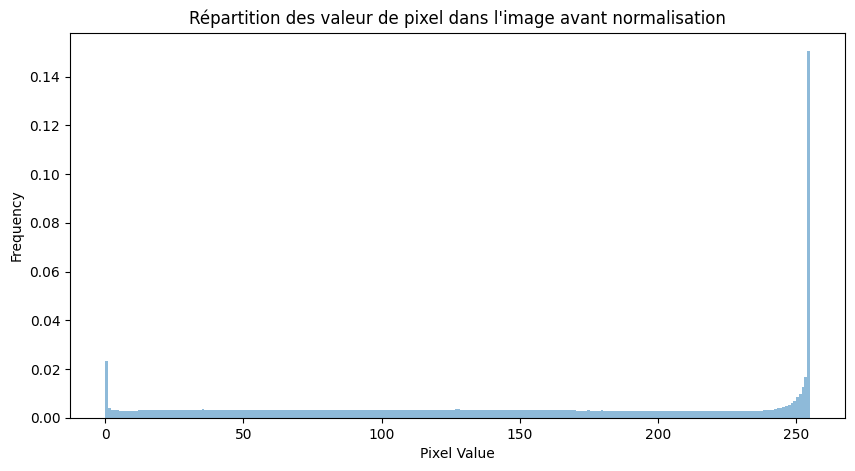

In [6]:
plot_pixel_distribution(temp_dataset, 'Répartition des valeur de pixel dans l\'image avant normalisation')

In [5]:
def normalize(image, label):
    return tf.multiply(image, 1./255), label

In [6]:
train_dataset = train_dataset.map(normalize)

In [7]:
temp_dataset = temp_dataset.map(normalize)

Voici la répartition des valeurs des pixels après la normalisation.

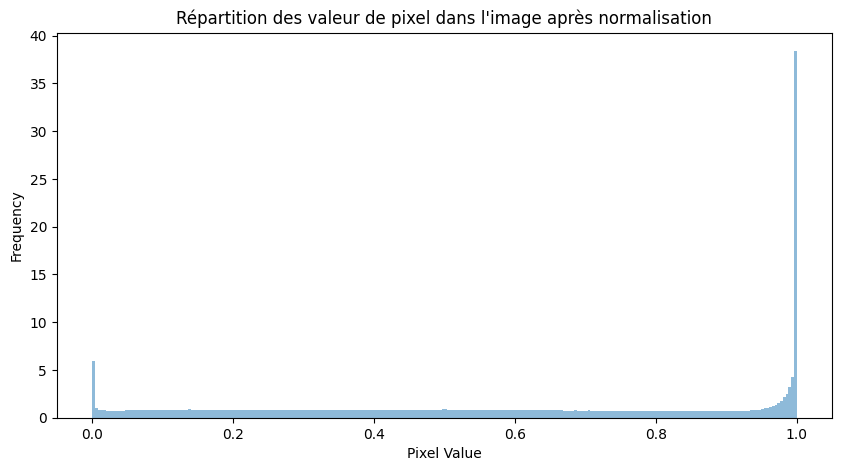

In [11]:
plot_pixel_distribution(temp_dataset, 'Répartition des valeur de pixel dans l\'image après normalisation')

On peut voir icic que la répartition reste la même, alors que la plage des données est passée de 0-255 à 0-1. Cela permet de valider la réussite de la normalisation.

## 3. Tailles des jeux de données
Maintenant que nos données sont normalisées nous pouvons diviser notre jeu temporaire en 2 afin de créer les jeux de test et de validation.

In [8]:
# Calculer le nombre total de lots dans temp_dataset
num_batches = len(temp_dataset)

# Diviser temp_dataset en deux
val_dataset = temp_dataset.take(num_batches // 2)
test_dataset = temp_dataset.skip(num_batches // 2)

In [15]:
def count_elements(dataset):
    count = 0
    for _ in dataset:
        count += BATCH_SIZE
    return count

# Compter le nombre d'éléments dans chaque jeu de données
train_size = count_elements(train_dataset)
val_size = count_elements(val_dataset)
test_size = count_elements(test_dataset)

# Afficher la taille de chaque jeu de données
print(f"Taille du jeu d'entraînement: {train_size} images")
print(f"Taille du jeu de validation: {val_size} images")
print(f"Taille du jeu de test: {test_size} images")

Taille du jeu d'entraînement: 43008
Taille du jeu de validation: 9216
Taille du jeu de test: 9216


## 2. Construction du modèle

In [9]:
model = None
with tf.device('/GPU:0'):
    #Initialisation du modèle
    model = Sequential()

    # Première couche de convolution
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Deuxième couche de convolution
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Troisième couche de convolution
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 4eme couche de convolution
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Aplatir les résultats pour les connecter à une couche dense
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    # Couche de sortie
    model.add(Dense(1, activation='sigmoid'))

    # Compilation du modèle
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## 3. Entraînement du modèle

In [10]:
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model_checkpoint_directory = f"weights/checkpoint/{date}/"
os.makedirs(model_checkpoint_directory, exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{model_checkpoint_directory}{{epoch:02d}}-{{val_loss:.4f}}.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    save_freq='epoch',
    save_best_only=False)

model.fit(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[tensorboard_callback, model_checkpoint_callback])

Epoch 1/15
336/336 [==============================] - 41s 108ms/step - loss: 0.4046 - accuracy: 0.8095 - val_loss: 0.3342 - val_accuracy: 0.8474
Epoch 2/15
336/336 [==============================] - 34s 102ms/step - loss: 0.3191 - accuracy: 0.8610 - val_loss: 0.2895 - val_accuracy: 0.8721
Epoch 3/15
336/336 [==============================] - 35s 104ms/step - loss: 0.2726 - accuracy: 0.8847 - val_loss: 0.2581 - val_accuracy: 0.8947
Epoch 4/15
336/336 [==============================] - 35s 103ms/step - loss: 0.2388 - accuracy: 0.9005 - val_loss: 0.2300 - val_accuracy: 0.9032
Epoch 5/15
336/336 [==============================] - 35s 103ms/step - loss: 0.2134 - accuracy: 0.9134 - val_loss: 0.2449 - val_accuracy: 0.8936
Epoch 6/15
336/336 [==============================] - 35s 104ms/step - loss: 0.1913 - accuracy: 0.9227 - val_loss: 0.2362 - val_accuracy: 0.9017
Epoch 7/15
336/336 [==============================] - 34s 102ms/step - loss: 0.1728 - accuracy: 0.9310 - val_loss: 0.2031 - val_ac

**Chargement des poids du modèle à la fin de la meilleure époque.**   
   
![image.png](attachment:ce5b6758-97f8-40bc-82e5-3ca4697fd1a6.png)
![image.png](attachment:ad3a5d14-e0ab-472a-8c98-ea59ebe5b6df.png)
   
On peut voir ici que le modèle commence un surapprentissage après l'époque 7. En effet, à ce moment, la perte du jeu de validation commence à augmenter et l'accuracy du jeu de validation reste à peu près stable. Pendant ce temps, l'évaluation du jeu d'entraînement continue à s'améliorer. Dans ce cas, le modèle ne sera performant que sur les données d'entrainement et ne sera pas assez général.   
   
On charge donc les poids que le modèle avait à la fin de la 7ème époque.

In [11]:
model.load_weights("./weights/checkpoint/20231003-155815/07-0.2031.h5")

## 4. Evaluation du modèle
Afin de valider le modèle, nous allons étudier sa performance sur le jeu de test, c'est à dire des images qu'il n'as jamais vu pendant l'entraînement.

### 4.1. Loss et Accuracy

In [12]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

72/72 [==============================] - 6s 43ms/step - loss: 0.2215 - accuracy: 0.9089
Loss: 0.22150015830993652
Accuracy: 0.9089031219482422


On peut voir ici que le modèle effectue la bonne prédiction environ 9 fois sur 10.

### 4.2. Matrice de confusion

4/4 [==============================] - 0s 11ms/step


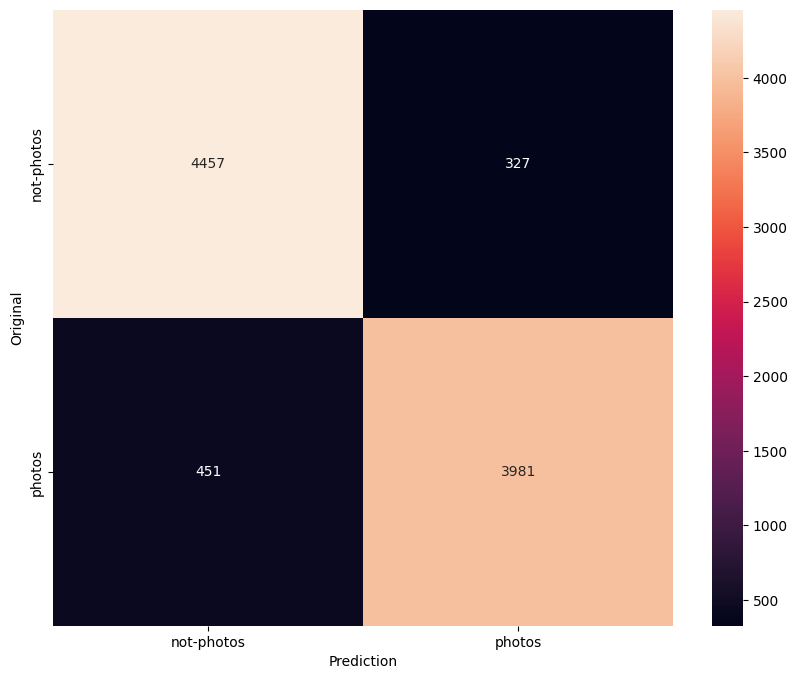

In [14]:
# Get the true labels and predictions
true_labels = []
predictions = []

for img, label in val_dataset:
    pred = model.predict(img)
    pred = tf.round(pred).numpy().flatten()  # Round the predictions to get binary output
    predictions.extend(pred)
    true_labels.extend(label.numpy())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(true_labels, predictions)

# If you want to visualize the confusion matrix using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ["not-photos", "photos"]

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Original')
plt.show()

Cette matrice de confusion permet de comprendre les erreurs du modèle.   
Sur les 9216 images du jeu de test :   
- 4457 non-photos on été correctement prédites  (vrai négatifs)
- 3981 photos ont été correctement prédites     (vrai positifs)
- 327 non-photos ont été prédites comme photos  (faux positis)
- 451 photos ont été prédites comme non-photos  (faux négatifs)   
   
Pour améliorer ce modèle, il faudrait réussir à limiter le nombre de faux positifs quitte à augmenter le nombre de faux négatifs. En effet, l'important ici est d'exclure les images qui ne sont pas des photos quitte à perdre quelques photos.

### 4.3. Visualisation des prédictions en erreur

288/288 [==============================] - 3s 9ms/step
False positive count : 323
False negative count : 458


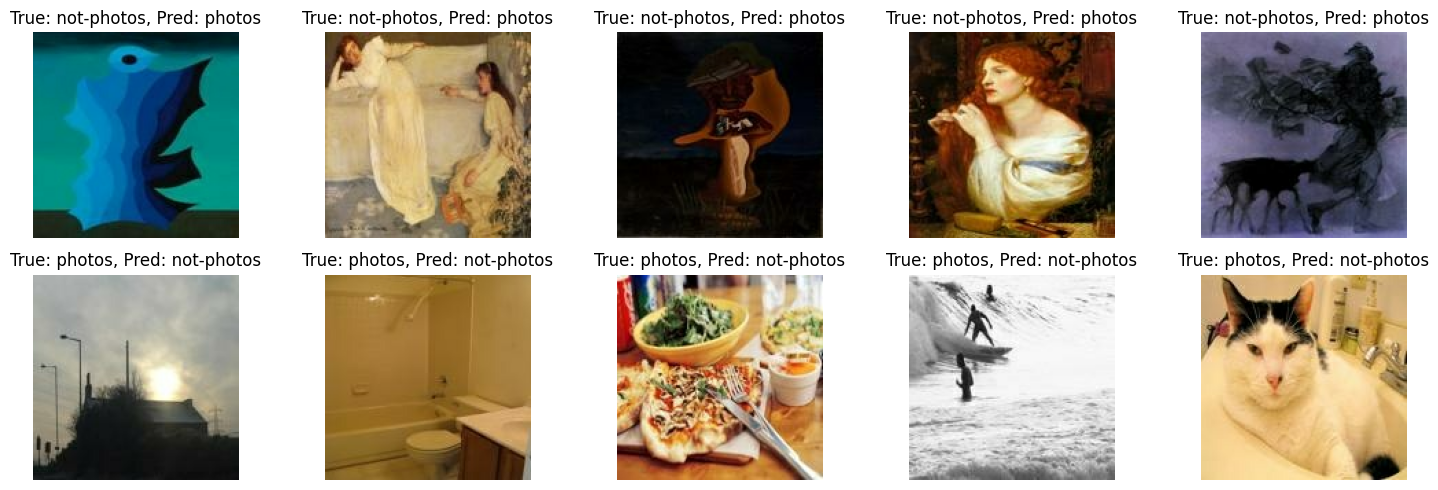

In [17]:
# Obtenez toutes les images et étiquettes du dataset pour éviter des appels répétés
all_images, all_labels = [], []
for img, label in val_dataset:
    all_images.extend(img.numpy())
    all_labels.extend(label.numpy())

# Convertissez les listes en numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Recalculez les prédictions pour toutes les images
all_predictions = model.predict(all_images)
all_predictions = tf.round(all_predictions).numpy().flatten()  # Arrondir les prédictions pour obtenir un résultat binaire

# Trouvez les indices des faux positifs et des faux négatifs
false_positive_indices = np.where((all_labels == 0) & (all_predictions == 1))[0]
false_negative_indices = np.where((all_labels == 1) & (all_predictions == 0))[0]

# Choisissez les 5 premiers faux positifs et faux négatifs
selected_fp_indices = false_positive_indices[:5]
selected_fn_indices = false_negative_indices[:5]

# Affichez les faux positifs
plt.figure(figsize=(15, 5))
for i, index in enumerate(selected_fp_indices, 1):
    plt.subplot(2, 5, i)
    plt.imshow(all_images[index])
    plt.title(f"True: {class_names[int(all_labels[index])]}, Pred: {class_names[int(all_predictions[index])]}")
    plt.axis('off')

# Affichez les faux négatifs
for i, index in enumerate(selected_fn_indices, 1):
    plt.subplot(2, 5, i + 5)
    plt.imshow(all_images[index])
    plt.title(f"True: {class_names[int(all_labels[index])]}, Pred: {class_names[int(all_predictions[index])]}")
    plt.axis('off')

print(f"False positive count : {len(false_positive_indices)}")
print(f"False negative count : {len(false_negative_indices)}")
plt.tight_layout()
plt.show()


Visualiser quelques erreurs de notre modèle permet de comprendre le genre d'images qui le met en difficulté.  
Généralement, les peintures réalistes et les photos en noir et blanc ont tendance à mettre le modèle en difficulté.  
Sentez-vous libre d'afficher plus de prédictions en erreur pour mieux comprendre les images difficiles.